In [11]:
import numpy as np
import healpy as hp
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pylab as plt
import matplotlib.patches as patches
import astropy.io.fits as pyfits
from scipy.stats import binned_statistic
from astropy.io import ascii
import matplotlib.cm as cm
from healpy.newvisufunc import projview, newprojplot
import pylab as pl
import math
from astropy.io import fits
import random
import csv
import sys
import scipy


In [25]:
#import all information from the data set of alfalfa hi source catalog

hi_source = np.genfromtxt('alfalfa.csv',delimiter = ',')#import the data file
ra_all=hi_source[:,2]#get the coordinate ra (in degrees)from the data
ra_all=np.delete(ra_all,0)#delete the first row of names
dec_all=hi_source[:,3]#get the dec from the data (unit:degrees)
dec_all=np.delete(dec_all,0)
hi_mass_all=hi_source[:,16]#get the hi mass
hi_mass_all=np.delete(hi_mass_all,0)
hi_v=hi_source[:,6]# get the heliocentric velocity for later calculation of redshifts in km/s
hi_v=np.delete(hi_v,0)

In [27]:
hi_z=hi_v*(10**3)/scipy.constants.c #calculate the redshifts according to v=cz, where c is the speed of light

#select the galaxies within the range of 0.0025<z<0.05

ra_hi=np.array([])
dec_hi=np.array([])
hi_mass=np.array([])
for i in range(hi_z.size):
    if 0.0025<hi_z[i]<0.05:
        ra_hi=np.append(ra_hi,ra_all[i])
        dec_hi=np.append(dec_hi,dec_all[i])
        hi_mass=np.append(hi_mass,hi_mass_all[i])

In [28]:
#the function that construct the density map

from astropy.coordinates import SkyCoord

def count_map(ra, dec, nside):
    eq = SkyCoord(ra, dec, unit='deg')
    l, b = eq.galactic.l.value, eq.galactic.b.value #transfer the radec coordinates into lonlat in degree
    m = np.zeros(hp.nside2npix(nside))#construct the map
    index=hp.ang2pix(nside,l,b,lonlat=True)
    idx, counts = np.unique(index, return_counts=True)#count the number of galaxies per pixel
    m[idx] = counts #plug the number of galaxies

    return m


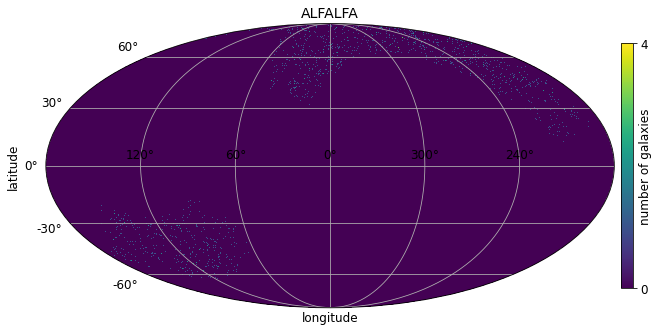

In [29]:
#plot the z-selected galaxies into the map
m = count_map(ra_hi, dec_hi, nside=512)
density = m #copy the map for making the mask later
projview(
    density,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    unit="number of galaxies",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="vertical",
    projection_type="mollweide",
    title="ALFALFA",xsize=800
);

In [30]:
#make the mask of the map

nside=512
npix=hp.nside2npix(nside)

#get the radec coordinates of all indexed pixels of a map with nside=512
lon, lat = hp.pix2ang(nside, range(npix), lonlat=True)
coord = SkyCoord(l=lon, b=lat, frame='galactic', unit='deg')
ra_all = coord.icrs.ra.value
dec_all = coord.icrs.dec.value

for i in range(npix):
    ra=ra_all[i]
    dec=dec_all[i]
    #check if the indexed pixel is in area 1
    if 115<=ra<=250:
            if (0<=dec and dec<=30):
                m[i]=hp.UNSEEN
    #check if the indexed pixel is in area 2
    if (0<=ra<=45):
        if (0<=dec<=32):
            m[i]=hp.UNSEEN
    if (ra>=330):
        if (0<=dec<=32):
            m[i]=hp.UNSEEN
            
hi_mask=hp.mask_bad(m)

0.0 180.0 -180.0 180.0


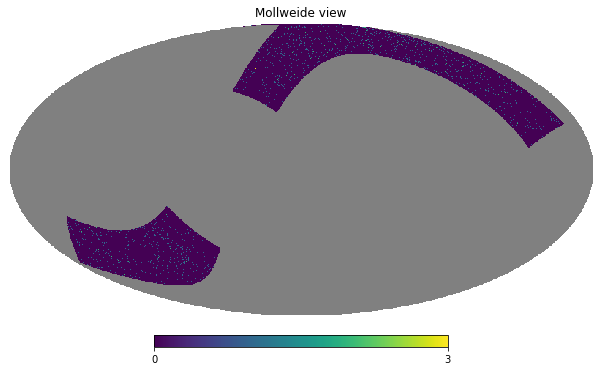

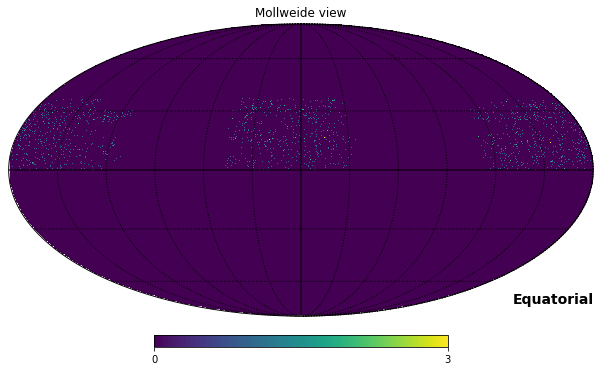

In [31]:
#put mask to the map

density = count_map(ra_hi, dec_hi, nside=512)#since map m was used to make the mask
density_masked=hp.ma(density)
density_masked.mask = np.logical_not(hi_mask)

#project the map to check if the mask was correctly generated
hp.mollview(density_masked)

hp.mollview(density,coord=['G','C'],rot=0)
hp.graticule()

In [39]:
#divide up the galaxies into different HI mass groups

mass = np.array([hi_mass,dec_hi,ra_hi]) #combine the arrays into one for further operations
mass = mass [ :, mass[0].argsort()] #sort the array mass according to th size of hi_mass,from low to high
sorted_hi_mass = mass[0,:]#cut out the first row, which is the hi mass, for further operations

# massi for i in range(1,13) refers to different bins of masses

for i in range(13):
    k=8+0.2*i #k is the constraints (hi mass) on different groups
    index=np.where(sorted_hi_mass[sorted_hi_mass < k])
    globals()['mass%s' % (i+1)] =np.delete(mass,index,1) # construct mass groups according to their hi masses


#calculate the total number of galaxies in each group

N_g=np.zeros(13)
for i in range(0,13):
    N_g[i]=globals()['mass%s' % (i+1)].size/3

#calculate the mean number of galaxies per pixel of each group
total_pix=np.sum(hi_mask)
n_g_mean=N_g/total_pix

# Method 1: cancel the shot noise(assumes that shot noise=1/n_g_mean)

In [40]:
#construct a function that returns the density contrast map (not the density map as function count_map)
def contrast(ra, dec, nside, n_g_mean):
    eq = SkyCoord(ra, dec, unit='deg')
    l, b = eq.galactic.l.value, eq.galactic.b.value
    m = np.zeros(hp.nside2npix(nside))
    index=hp.ang2pix(nside,l,b,lonlat=True)
    idx, counts = np.unique(index, return_counts=True)#same as the density map
    m[idx] =counts#same as the density map
    m=(m-n_g_mean)/n_g_mean#compute the contrast density

    return m


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


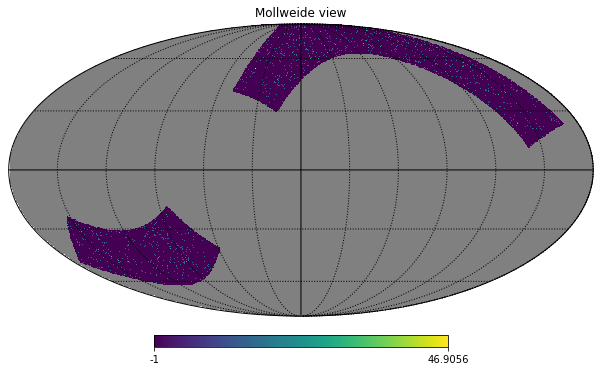

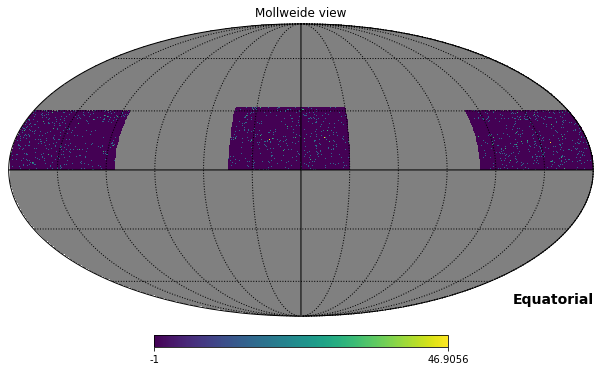

In [41]:

for i in range(13):
    #make the contrast maps of different groups
    globals()['mass_map_noisefree%s' % (i+1)]=contrast(globals()['mass%s' % (i+1)][2], globals()['mass%s' % (i+1)][1], nside=512,n_g_mean=n_g_mean[i])
    #mask the maps
    globals()['mass_map_mask%s' % (i+1)]=hp.ma(globals()['mass_map_noisefree%s' % (i+1)])
    globals()['mass_map_mask%s' % (i+1)].mask = np.logical_not(hi_mask)

#project the map for check
hp.mollview(mass_map_mask1.filled())
hp.graticule()
hp.mollview(mass_map_mask1.filled(),coord=['G','C'],rot=0)
hp.graticule()

In [45]:
#calculate the cl for each map and substract the shot noise
for i in range(13):
    globals()['cl_%s' % (i+1)]=hp.anafast(globals()['mass_map_mask%s' % (i+1)])-1/n_g_mean[i]
    globals()['ell_%s' % (i+1)]=np.arange(len( globals()['cl_noised_%s' % (i+1)]))

Text(0.52, 0.32, '$M_{HI}>10^{10.4}$')

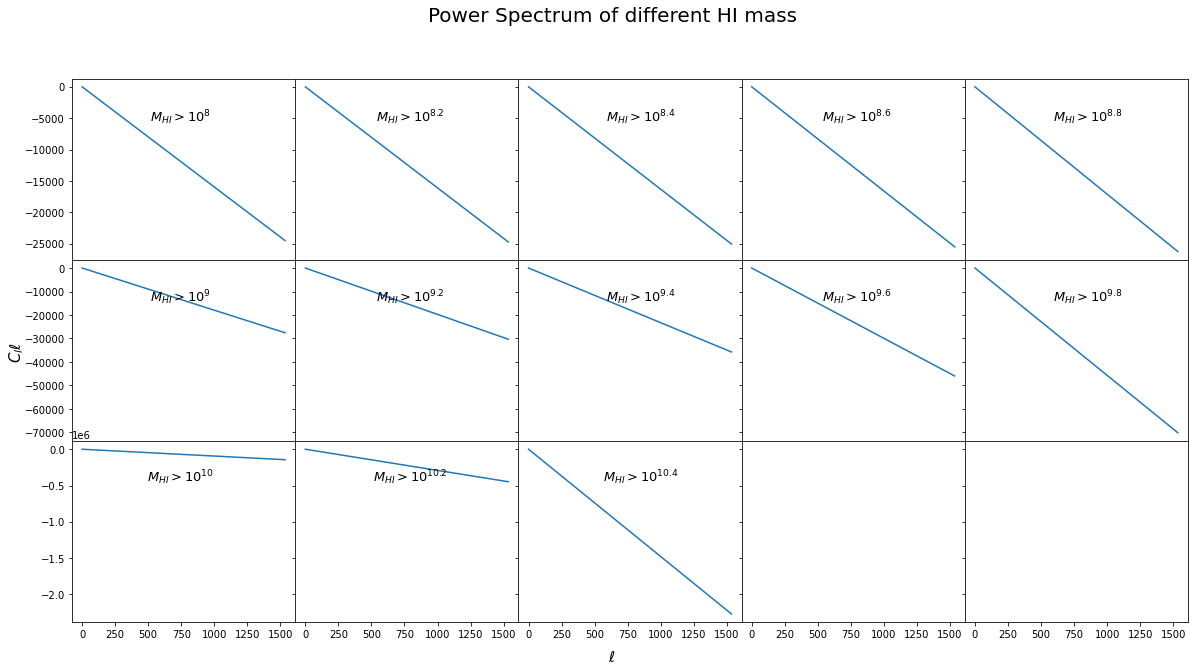

In [46]:
#plot the results

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(3, 5, hspace=0, wspace=0)
(ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Power Spectrum of different HI mass',fontsize=20)

ax1.plot(ell_1, ell_1*cl_1)
#ax1.set_yscale('log')
ax2.plot(ell_2, ell_2*cl_2)
ax3.plot(ell_3, ell_3*cl_3)
ax4.plot(ell_4, ell_4*cl_4)
ax5.plot(ell_5, ell_5*cl_5)
ax6.plot(ell_6, ell_6*cl_6)
#ax6.set_yscale('log')
ax7.plot(ell_7, ell_7*cl_7)
ax8.plot(ell_8, ell_8*cl_8)
ax9.plot(ell_9, ell_9*cl_9)
ax10.plot(ell_10, ell_10*cl_10)
ax11.plot(ell_11, ell_11*cl_11)
#ax11.set_yscale('log')
ax12.plot(ell_12, ell_12*cl_12)
ax13.plot(ell_13, ell_13*cl_13)
    
fig.text(0.5, 0.07, '$\ell$', ha='center',fontsize=15)
fig.text(0.08, 0.5, '$C_l \ell$', va='center', rotation='vertical',fontsize=15)

#name each subplot
fig.text(0.2, 0.82, '$M_{HI}>10^8$', ha='center',fontsize=13)
fig.text(0.36, 0.82, '$M_{HI}>10^{8.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.82, '$M_{HI}>10^{8.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.82, '$M_{HI}>10^{8.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.82, '$M_{HI}>10^{8.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.57, '$M_{HI}>10^9$', ha='center',fontsize=13)
fig.text(0.36, 0.57, '$M_{HI}>10^{9.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.57, '$M_{HI}>10^{9.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.57, '$M_{HI}>10^{9.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.57, '$M_{HI}>10^{9.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.32, '$M_{HI}>10^{10}$', ha='center',fontsize=13)
fig.text(0.36, 0.32, '$M_{HI}>10^{10.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.32, '$M_{HI}>10^{10.4}$', ha='center',fontsize=13)


# Method 2 to cancel the noise: Ando et al.

In [47]:
#randomly split the maps of different hi mass groups into half

#randomly split the indices of pixels into two groups
for i in range (13):
    size=np.arange(int(N_g[i]))
    globals()['map_1_index_%s' % (i+1)]=np.random.choice(size,int(N_g[i]/2),replace=False)
    globals()['map_2_index_%s' % (i+1)]=np.delete(size,globals()['map_1_index_%s' % (i+1)])

#then split the catalog array of each mass groups with the indices generated previously
for i in range(13):
    globals()['mass_1_%s' % (i+1)]=np.array([[0],[0],[0]])
    globals()['mass_2_%s' % (i+1)]=np.array([[0],[0],[0]])
    for j in (globals()['map_1_index_%s' % (i+1)]):
        a=[[globals()['mass%s' % (i+1)][0,j]],[globals()['mass%s' % (i+1)][1,j]],[globals()['mass%s' % (i+1)][2,j]]]
        globals()['mass_1_%s' % (i+1)]=np.append(globals()['mass_1_%s' % (i+1)],a,axis=1)
    for k in (globals()['map_2_index_%s' % (i+1)]):
        b=[[globals()['mass%s' % (i+1)][0,k]],[globals()['mass%s' % (i+1)][1,k]],[globals()['mass%s' % (i+1)][2,k]]]
        globals()['mass_2_%s' % (i+1)]=np.append(globals()['mass_2_%s' % (i+1)],b,axis=1)

#delete the first column which was used to define the shape of array
for i in range(13):
    globals()['mass_1_%s' % (i+1)]=np.delete(globals()['mass_1_%s' % (i+1)],0,axis=1)
    globals()['mass_2_%s' % (i+1)]=np.delete(globals()['mass_2_%s' % (i+1)],0,axis=1)

In [48]:
#construct and mask the map for each mass groups

for i in range(13):
    globals()['map_1_%s' % (i+1)]=contrast(globals()['mass_1_%s' % (i+1)][2], globals()['mass_1_%s' % (i+1)][1], nside=512,n_g_mean=n_g_mean[i])
    globals()['map_1_masked_%s' % (i+1)]=hp.ma(globals()['map_1_%s' % (i+1)])
    globals()['map_1_masked_%s' % (i+1)].mask = np.logical_not(hi_mask)
    
    globals()['map_2_%s' % (i+1)]=contrast(globals()['mass_2_%s' % (i+1)][2], globals()['mass_2_%s' % (i+1)][1], nside=512,n_g_mean=n_g_mean[i])
    globals()['map_2_masked_%s' % (i+1)]=hp.ma(globals()['map_2_%s' % (i+1)])
    globals()['map_2_masked_%s' % (i+1)].mask = np.logical_not(hi_mask)

In [49]:
# make the hd and hs map for each mass groups

for i in range(13):
    #HS=(map_1+map_2)/2 and HD=(map_1-map_2)/2
    globals()['HS_%s' % (i+1)]=(globals()['map_1_masked_%s' % (i+1)]+globals()['map_2_masked_%s' % (i+1)])/2
    globals()['HD_%s' % (i+1)]=(globals()['map_1_masked_%s' % (i+1)]-globals()['map_2_masked_%s' % (i+1)])/2

In [51]:
#find the cl for all HS,HD, the final cl and ell

for i in range(13):
    globals()['cl_HS_%s' % (i+1)]=hp.anafast(globals()['HS_%s' % (i+1)],use_pixel_weights=True)
    globals()['cl_HD_%s' % (i+1)]=hp.anafast(globals()['HD_%s' % (i+1)],use_pixel_weights=True)
    #the noise cancelled power spectrum is cl=cl_hs-cl_hd
    globals()['cl_%s' % (i+1)]=globals()['cl_HS_%s' % (i+1)]-globals()['cl_HD_%s' % (i+1)]
    globals()['ell_%s' % (i+1)]=np.arange(len(globals()['cl_%s' % (i+1)]))

Text(0.52, 0.32, '$M_{HI}>10^{10.4}$')

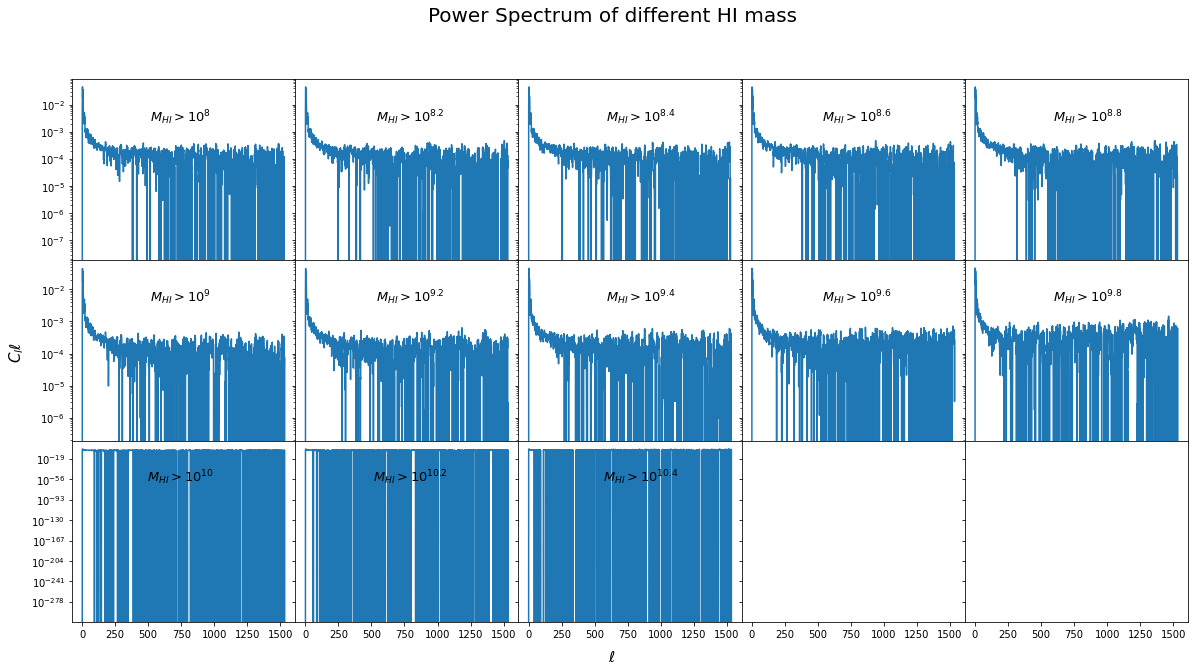

In [52]:
#plot the power spectrum


fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(3, 5, hspace=0, wspace=0)
(ax1, ax2,ax3,ax4,ax5), (ax6, ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Power Spectrum of different HI mass',fontsize=20)

ax1.plot(ell_1, ell_1*cl_1)
ax1.set_yscale('log')
ax2.plot(ell_2, ell_2*cl_2)
ax3.plot(ell_3, ell_3*cl_3)
ax4.plot(ell_4, ell_4*cl_4)
ax5.plot(ell_5, ell_5*cl_5)
ax6.plot(ell_6, ell_6*cl_6)
ax6.set_yscale('log')
ax7.plot(ell_7, ell_7*cl_7)
ax8.plot(ell_8, ell_8*cl_8)
ax9.plot(ell_9, ell_9*cl_9)
ax10.plot(ell_10, ell_10*cl_10)
ax11.plot(ell_11, ell_11*cl_11)
ax11.set_yscale('log')
ax12.plot(ell_12, ell_12*cl_12)
ax13.plot(ell_13, ell_13*cl_13)
    
fig.text(0.5, 0.07, '$\ell$', ha='center',fontsize=15)
fig.text(0.08, 0.5, '$C_l \ell$', va='center', rotation='vertical',fontsize=15)

#name each subplot
fig.text(0.2, 0.82, '$M_{HI}>10^8$', ha='center',fontsize=13)
fig.text(0.36, 0.82, '$M_{HI}>10^{8.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.82, '$M_{HI}>10^{8.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.82, '$M_{HI}>10^{8.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.82, '$M_{HI}>10^{8.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.57, '$M_{HI}>10^9$', ha='center',fontsize=13)
fig.text(0.36, 0.57, '$M_{HI}>10^{9.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.57, '$M_{HI}>10^{9.4}$', ha='center',fontsize=13)
fig.text(0.67, 0.57, '$M_{HI}>10^{9.6}$', ha='center',fontsize=13)
fig.text(0.83, 0.57, '$M_{HI}>10^{9.8}$', ha='center',fontsize=13)
fig.text(0.2, 0.32, '$M_{HI}>10^{10}$', ha='center',fontsize=13)
fig.text(0.36, 0.32, '$M_{HI}>10^{10.2}$', ha='center',fontsize=13)
fig.text(0.52, 0.32, '$M_{HI}>10^{10.4}$', ha='center',fontsize=13)


# Variance calculation

In [57]:
#define the function to calculate the gaussian covariance

def cov(l_1,l_2,cl_w_noise,f_sky,delta_l):
    covariance=(2*(cl_w_noise[l_1])**2)*np.kron(l_1,l_2)/(f_sky*(2*l_1+1)*delta_l)
    return covariance


In [58]:
#calculate the cl with shot noise
for i in range(13):
    globals()['cl_w_noise_%s' % (i+1)]=hp.anafast(globals()['mass_map_mask%s' % (i+1)])

In [59]:

f_sky=np.sum(hi_mask)/hp.nside2npix(512)#fraction of sky
delta_l=50 #depends on how the user want to bin the power spectrum
n_bins=int(ell.size/delta_l) #the number of bins

for i in range(13):
    globals()['cov_cl_%s' % (i+1)]=np.array([])
    l_1=1#the first l to start with
    l_2=l_1+delta_l
    for j in range(n_bins):
        globals()['cov_cl_%s' % (i+1)]=np.append(globals()['cov_cl_%s' % (i+1)],cov(l_1,l_2,globals()['cl_w_noise_%s' % (i+1)],f_sky,delta_l))
        l_1=l_1+delta_l
        l_2=l_2+delta_l
    globals()['cov_cl_%s' % (i+1)]=np.sqrt(globals()['cov_cl_%s' % (i+1)])#calculate the gaussian variance